# Setting working directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/FinanceRiskControl')

Go to this place for original dataset: 

`'/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/FinanceRiskControl/originalDataset'`

# Importing libraries and load datasets

In [ ]:
!pip install catboost

     |████████████████████████████████| 66.3MB 82kB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
# import tqdm
warnings.filterwarnings('ignore')

# Starting feature engineering

## Load dataset

In [ ]:
data_train = pd.read_csv('originalDataset/train.csv')
data_test_a = pd.read_csv('originalDataset/testA.csv')

## Numerical features and category features

In [ ]:
# numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns)
# category_fea = list(filter(lambda x: x not in numerical_fea,list(data_train.columns)))
# label = 'isDefault'
# numerical_fea.remove(label)

In [ ]:
# category_fea

In [ ]:
# #过滤数值型类别特征
# def get_numerical_serial_fea(data,feas):
#     numerical_serial_fea = []
#     numerical_noserial_fea = []
#     for fea in feas:
#         temp = data[fea].nunique()
#         if temp <= 10:
#             numerical_noserial_fea.append(fea)
#             continue
#         numerical_serial_fea.append(fea)
#     return numerical_serial_fea,numerical_noserial_fea
# numerical_serial_fea,numerical_noserial_fea = get_numerical_serial_fea(data_train,numerical_fea)

In [ ]:
# numerical_fea

In [ ]:
# numerical_noserial_fea

In [ ]:
# category_fea

## Classify the features into multiple categories

In [ ]:
total_list = sorted(list(data_train.columns))

In [ ]:
numerical_category_fewValues = [
    "homeOwnership", 
    "verificationStatus",
    "initialListStatus",
    "applicationType",
    "n11",
    "n12",
]

In [ ]:
numerical_category_manyValues = [
    "regionCode",
    "employmentTitle",
    "purpose",
    "postCode",
    "title",
]

In [ ]:
date_type = [
    "issueDate", 
    "earliesCreditLine"
]

In [ ]:
numerical_serial = [
    "loanAmnt","interestRate","installment","annualIncome","dti","delinquency_2years","ficoRangeLow","ficoRangeHigh","openAcc",
    "pubRec","pubRecBankruptcies","revolBal","revolUtil","totalAcc","n0","n1","n2","n3",
    "n4","n5","n6","n7","n8","n9","n10","n13","n14",
    "term", 
]

In [ ]:
object_serial = [
    "grade",
    "subGrade", 
    "employmentLength"
]

In [ ]:
# len(numerical_category_fewValues) + len(numerical_category_manyValues) + len(date_type) + len(numerical_serial) + len(object_serial)
new_cates = numerical_category_fewValues + numerical_category_manyValues + date_type + numerical_serial + object_serial

In [ ]:
set(total_list) - set(new_cates)

{'id', 'isDefault', 'policyCode'}

In [ ]:
# data_train = data_train.head(200)
# data_test_a = data_test_a.head(200)

## Fill the null. 

**Mind this**: Some other filling schemes can be used. 

In [ ]:
# data_train.isnull().sum()

In [ ]:
# data_train["n14"].head()

In [ ]:
## Change the infinite number into NaN. 
# data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
# data_test_a.replace([np.inf, -np.inf], np.nan, inplace=True)

Lagrange interpolation

In [ ]:
# 创建函数，做插值，以空值前后5个数据（共10个数据）为例做插值  
from scipy.interpolate import lagrange  

## https://www.programmersought.com/article/37145216331/
def fillNanWithLagr(col,nv=-1,k=3):
    # col "fill column vector", nv "empty value, default -1", k "Lagrangian interval, default 3"
    # Get the null position
    if nv is np.nan:
        tar = col[col.isnull()].index.tolist()
    else:
        tar = col[col==nv].index.tolist()

    for idx in tqdm.tqdm(tar, position=0, leave=True):
      ## you can also use tqdm.tqdm_notebook(). The graphic info is more beautiful. 
    # for idx in tqdm.tqdm(tar):
                # Get Lagrange interval
                # The empty value position is removed here, because the filled empty value cannot be used to calculate other empty values
        # print(idx, end="")
        rel = col.iloc[
            list(
                set(list(range(idx-k,idx))+list(range(idx+1,idx+k+1))).difference(set(tar))
            )
        ]
                # Keep a reasonable range
        rel = rel[rel>=0][rel<len(col)]
                # Fill in Lagrangian mean
        # lagrange(arg1,arg2)(arg3)
                # arg1 "Iterable object index", arg2 "Iterable object conversion table", arg3 "Fill position"
        col.iloc[idx] = lagrange(rel.index,list(rel))(idx)
    return col

In [ ]:
# # data_train_cp = data_train.copy()
# # data_test_a_cp = data_test_a.copy()

# for i, data in enumerate([data_train, data_test_a]):
#     print("in the {} dataset:".format(i + 1))
#     for fea in numerical_fea:
#         if fea == "id":
#             continue
#         print(fea)
#         data[fea] = fillNanWithLagr(data[fea], np.nan, 5)

In [ ]:
# data_train.to_csv("preprocessedData/lagrangeInterpolated_train.csv", index=False)
# data_test_a.to_csv("preprocessedData/lagrangeInterpolated_test.csv", index=False)

Median interpolation

In [ ]:
# #按照平均数填充数值型特征
# data_train[numerical_fea] = data_train[numerical_fea].fillna(data_train[numerical_fea].median())
# data_test_a[numerical_fea] = data_test_a[numerical_fea].fillna(data_train[numerical_fea].median())
# #按照众数填充类别型特征
# data_train[category_fea] = data_train[category_fea].fillna(data_train[category_fea].mode())
# data_test_a[category_fea] = data_test_a[category_fea].fillna(data_train[category_fea].mode())

`employmentLength` cannot be filled by `mode()`. I don't know why. 

In [ ]:
# data_train.info()

In [ ]:
# data_train = data_train.fillna(axis = 0, method = "ffill")

### Scheme A

No filling

In [ ]:
## No filling of any null value

## Change `object_serial` 


### Scheme A

Change the `subGrade`, `grade`, `employmentLength`

In [ ]:
for col in tqdm(['subGrade', 'grade']): #, 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode'
    le = LabelEncoder()
    le.fit(list(data_train[col].astype(str).values) + list(data_test_a[col].astype(str).values))
    data_train[col] = le.transform(list(data_train[col].astype(str).values))
    data_test_a[col] = le.transform(list(data_test_a[col].astype(str).values))

100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


In [ ]:
data_train['employmentLength'].value_counts(dropna=False).sort_index()

1 year        52489
10+ years    262753
2 years       72358
3 years       64152
4 years       47985
5 years       50102
6 years       37254
7 years       35407
8 years       36192
9 years       30272
< 1 year      64237
NaN           46799
Name: employmentLength, dtype: int64

In [ ]:
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0]) ## mind this. use the int type in np, not general python int. 
    
for data in [data_train, data_test_a]:
    data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
    data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [ ]:
## `employmentLength` can be filled by `mean()`. Great.
# data_train['employmentLength'].fillna(data_train["employmentLength"].mean(), inplace = True)
# data_test_a['employmentLength'].fillna(data_test_a["employmentLength"].mean(), inplace = True)
# data_train.info()

## Change `date_type` 


### Scheme A

In [ ]:
#转化成时间格式
for data in [data_train, data_test_a]:
    # data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    # #构造时间特征
    data['issueYear'] = data['issueDate'].apply(lambda x: int(x.split("-")[0]))
    data['issueMonth'] = data['issueDate'].apply(lambda x: int(x.split("-")[1]))

In [ ]:
#转化成时间格式
def monthMapping(monthStr):
    dic = {
        "Jan": 1, 
        "Feb": 2, 
        "Mar": 3,
        "Apr": 4,
        "May": 5, 
        "Jun": 6, 
        "Jul": 7, 
        "Aug": 8, 
        "Sep": 9,
        "Oct": 10, 
        "Nov": 11,
        "Dec": 12
    }
    return dic[monthStr]

for data in [data_train, data_test_a]:
    # data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    # #构造时间特征
    data['earliesCreditLineYear'] = data['earliesCreditLine'].apply(lambda x: int(x.split("-")[1]))
    data['earliesCreditLineMonth'] = data['earliesCreditLine'].apply(lambda x: monthMapping(x.split("-")[0]))

In [ ]:
#转化成时间格式
startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
for data in [data_train, data_test_a]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    #构造时间特征
    data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days

In [ ]:
startmonth = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
for data in [data_train, data_test_a]:
    data["earliesCreditLine"] = data["earliesCreditLine"].apply(lambda x: datetime.datetime.strptime(x, '%b-%Y'))
    data["earliesCreditLineDT"] = data["earliesCreditLine"].apply(lambda x: x-startdate).dt.days

In [ ]:
date_type += [
    "issueDateDT", "earliesCreditLineDT", "earliesCreditLineYear", "earliesCreditLineMonth", 
    "issueYear", "issueMonth"
]
date_type

['issueDate',
 'earliesCreditLine',
 'issueDateDT',
 'earliesCreditLineDT',
 'earliesCreditLineYear',
 'earliesCreditLineMonth',
 'issueYear',
 'issueMonth']

## Change `numerical_serial` 


In [ ]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data

In [ ]:
data_train_cp = data_train.copy()
feaList = []
numList = []
for fea in numerical_serial:
    # if fea in ['homeOwnership', 'verificationStatus', "applicationType", "initialListStatus", "policyCode"]:
    #     continue
    data_train_cp = find_outliers_by_3segama(data_train_cp,fea)
    valCount = data_train_cp[fea+'_outliers'].value_counts()
    abnormalRate = 1-valCount["正常值"] / len(data_train_cp)
    if abnormalRate > 0.00001:
        feaList.append(fea)
        numList.append(abnormalRate)
        # print(valCount, "\n") ## 获得正常值和异常值的数量
        # print(1-valCount["正常值"] / len(data_train_cp), "\n") ## 获得正常值和异常值的数量
        # print(data_train_cp.groupby(fea+'_outliers')['isDefault'].sum(), "\n") ## 获得异常值和正常值里面有多少个正例
        # print('*'*100)

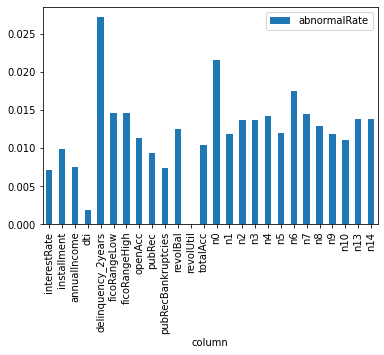

In [ ]:
tmpPd = pd.DataFrame({
    "column": feaList, 
    "abnormalRate": numList,
})
tmpPd.set_index(["column"], inplace=True)
tmpPd.plot(kind='bar')

In [ ]:
import numpy as np
from scipy.stats import chi
import pandas as pd
from pandas import DataFrame,Series
import scipy

def chi3(arr):
    '''
    计算卡方值
    arr:频数统计表,二维numpy数组。
    '''
    assert(arr.ndim==2)
    #计算每行总频数
    R_N = arr.sum(axis=1)
    #每列总频数
    C_N = arr.sum(axis=0)
    #总频数
    N = arr.sum()
    # 计算期望频数 C_i * R_j / N。
    E = np.ones(arr.shape)* C_N / N
    E = (E.T * R_N).T
    square = (arr-E)**2 / E
    #期望频数为0时，做除数没有意义，不计入卡方值
    square[E==0] = 0
    #卡方值
    v = square.sum()
    return v

def chiMerge(df,col,target,max_groups=None,threshold=None):

    '''
    卡方分箱
    df: pandas dataframe数据集
    col: 需要分箱的变量名（数值型）
    target: 类标签
    max_groups: 最大分组数。
    threshold: 卡方阈值，如果未指定max_groups，默认使用置信度95%设置threshold。
    return: 包括各组的起始值的列表.
    '''

    freq_tab = pd.crosstab(df[col],df[target])

    #转成numpy数组用于计算。
    freq = freq_tab.values

    #初始分组切分点，每个变量值都是切分点。每组中只包含一个变量值.

    #分组区间是左闭右开的，如cutoffs = [1,2,3]，则表示区间 [1,2) , [2,3) ,[3,3+)。
    cutoffs = freq_tab.index.values

    #如果没有指定最大分组
    if max_groups is None:    
        #如果没有指定卡方阈值，就以95%的置信度（自由度为类数目-1）设定阈值。
        if threshold is None:
            #类数目
            cls_num = freq.shape[-1]
            threshold = chi2.isf(0.05,df= cls_num - 1)

    while True:
        minvalue = None
        minidx = None
        #从第1组开始，依次取两组计算卡方值，并判断是否小于当前最小的卡方
        for i in range(len(freq) - 1):
            v = chi3(freq[i:i+2])
            if minvalue is None or (minvalue > v): #小于当前最小卡方，更新最小值
                minvalue = v
                minidx = i

        #如果最小卡方值小于阈值，则合并最小卡方值的相邻两组，并继续循环
        if  (max_groups is not None and  max_groups< len(freq) ) or (threshold is not None and minvalue < threshold):
            #minidx后一行合并到minidx
            tmp  = freq[minidx] + freq[minidx+1]
            freq[minidx] = tmp
            #删除minidx后一行
            freq = np.delete(freq,minidx+1,0)
            #删除对应的切分点
            cutoffs = np.delete(cutoffs,minidx+1,0)

        else: #最小卡方值不小于阈值，停止合并。
            break
    return cutoffs

def value2group(x,cutoffs):

    '''
    将变量的值转换成相应的组。
    x: 需要转换到分组的值
    cutoffs: 各组的起始值。
    return: x对应的组，如group1。从group1开始。
    '''

    #切分点从小到大排序。
    cutoffs = sorted(cutoffs)
    num_groups = len(cutoffs)

    #异常情况：小于第一组的起始值。这里直接放到第一组。
    #异常值建议在分组之前先处理妥善。
    if x < cutoffs[0]:
        return 1 #'group1'

    for i in range(1,num_groups):
        if cutoffs[i-1] <= x < cutoffs[i]:
            return i # 'group{}'.format(i)

    #最后一组，也可能会包括一些非常大的异常值。
    return num_groups #'group{}'.format(num_groups)

def calWOE(df ,var ,target):

    '''
    计算WOE编码
    param df：数据集pandas.dataframe
    param var：已分组的列名，无缺失值
    param target：响应变量（0,1）
    return：编码字典
    '''
    eps = 0.000001  #避免除以0
    gbi = pd.crosstab(df[var],df[target]) + eps
    gb = df[target].value_counts() + eps
    gbri = gbi/gb
    gbri['woe'] = np.log(gbri[1]/gbri[0])
    return gbri['woe'].to_dict()

def calIV(df,var,target):

    '''
    计算IV值
    param df：数据集pandas.dataframe
    param var：已分组的列名，无缺失值
    param target：响应变量（0,1）
    return：IV值
    '''
    eps = 0.000001  #避免除以0
    gbi = pd.crosstab(df[var],df[target]) + eps
    gb = df[target].value_counts() + eps
    gbri = gbi/gb
    gbri['woe'] = np.log(gbri[1]/gbri[0])
    gbri['iv'] = (gbri[1] - gbri[0])*gbri['woe']
    return gbri['iv'].sum()

### Scheme A

See abnormal values. Bin the columns that having many abnormal values. 我们仅查看异常值率大于0.015的。

`delinquency_2years, n0, n6` having abnormal values more than 1.5\%. 

In [ ]:
for fea in ["n0", "n6", "delinquency_2years"]:
    print("for feature: {}...".format(fea))
    cutoffs = chiMerge(data_train, fea,'isDefault',max_groups=10)
    data_train[fea] = data_train[fea].apply(value2group,args=(cutoffs,))
    data_test_a[fea] = data_test_a[fea].apply(value2group,args=(cutoffs,))

for feature: n0...
for feature: n6...
for feature: delinquency_2years...


### Scheme B

对全部的有异常值的列进行分箱

In [ ]:
for fea in [
            'interestRate',
            #'installment', #
            #'annualIncome',#
            #'dti', #
            'delinquency_2years',
            'ficoRangeLow',
            'ficoRangeHigh',
            'openAcc',
            'pubRec',
            'pubRecBankruptcies',
            #'revolBal', #
            'revolUtil',
            'totalAcc',
            'n0',
            'n1',
            'n2',
            'n3',
            'n4',
            'n5',
            'n6',
            'n7',
            'n8',
            'n9',
            'n10',
            'n13',
            'n14'
            ]:
    print("for feature: {}...".format(fea))
    cutoffs = chiMerge(data_train, fea,'isDefault',max_groups=10)
    data_train[fea] = data_train[fea].apply(value2group,args=(cutoffs,))
    data_test_a[fea] = data_test_a[fea].apply(value2group,args=(cutoffs,))

for feature: interestRate...
for feature: delinquency_2years...
for feature: ficoRangeLow...
for feature: ficoRangeHigh...
for feature: openAcc...
for feature: pubRec...
for feature: pubRecBankruptcies...
for feature: revolUtil...
for feature: totalAcc...
for feature: n0...
for feature: n1...
for feature: n2...
for feature: n3...
for feature: n4...
for feature: n5...
for feature: n6...
for feature: n7...
for feature: n8...
for feature: n9...
for feature: n10...
for feature: n13...
for feature: n14...


## Change `numerical_category_fewValues` 


### Scheme A

numerical_category_fewValues 被dummy了。

In [ ]:
data_train = pd.get_dummies(data_train, columns=numerical_category_fewValues, drop_first=True)
data_test_a = pd.get_dummies(data_test_a, columns=numerical_category_fewValues, drop_first=True)


In [ ]:
# data[["n11", "n12"]].head()
# for data in [data_train, data_test_a]:
#     data[["n11", "n12"]] = data[["n11", "n12"]].astype(int)

### Scheme B

不使用 dummy

In [ ]:
## Nothing is done. 

## Change `numerical_category_manyValues` 


###  Scheme A

不做处理

In [ ]:
## Nothing is done

## Feature Generation

利用 https://zhuanlan.zhihu.com/p/26444240 介绍的方法开展特征合成：

```
median(N1)_by(C1)  \\ 中位数
mean(N1)_by(C1)  \\ 算术平均数
mode(N1)_by(C1)  \\ 众数
min(N1)_by(C1)  \\ 最小值
max(N1)_by(C1)  \\ 最大值
std(N1)_by(C1)  \\ 标准差
var(N1)_by(C1)  \\ 方差
freq(C2)_by(C1)  \\ 频数

freq(C1) \\这个不需要groupby也有意义
```

In [ ]:
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr
#选择K个最好的特征，返回选择特征后的数据
#第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，
#输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
#参数k为选择的特征个数

def selectNFeatures(numSelectedFeatures, data_train, y_train, fillMethod = "ffill"):
    ## 无脑处理：将所有的正负无穷都处理掉。
    data_train = data_train.replace([np.inf, -np.inf], np.nan)
    ## 填充方法
    if fillMethod in ["ffill", "bfill"]:
        data_train = data_train.fillna(axis = 1, method = fillMethod) # "ffill"
    else: 
        data_train = data_train.fillna(data_train.median())  

    # print(data_train.isnull().sum())
    # print()
    # print(y_train.isnull().sum())
    # print(data_train.head(20))
    # print(np.any(np.isnan(data_train)))

    selector = SelectKBest(k=numSelectedFeatures)
    selector.fit(data_train, y_train)
    colNums = selector.get_support(True)
    selectedFeatures = []
    deletedFeatures = []
    for i, col in enumerate(list(data_train.columns)):
        if i in colNums:
            selectedFeatures.append(col)
        else: 
            deletedFeatures.append(col)
            
    return selectedFeatures, deletedFeatures

def combinationOfFeatures(category, serial, method, method_name, data_train, data_test_a, n):
    '''
    combine and generate some new features. 

    category: list of the categorical column names
    serial: list of the serial column names
    method: ["mean"], ["max"], ["min"], pd.Series.model, etc..
    method_name: the name of the method. Must be strings. 
    n: newly generated features, select n from them. if n == -1, then select all of the newly generated features. 
    '''
    new_cols = []
    
    for col in category: 
        for numFea in serial: #half_serials + ["isDefault"]: # for numFea in ["isDefault"]: 
            # print("categorical: {}, serial: {}".format(col, numFea))
            temp_dict = data_train.groupby([col])[numFea].agg(method).reset_index().rename(columns={method_name: col + '_{}_{}'.format(numFea, method_name)})
            temp_dict.index = temp_dict[col].values
            temp_dict = temp_dict[col + '_{}_{}'.format(numFea, method_name)].to_dict()
            
            data_train[col + '_{}_{}'.format(numFea, method_name)] = data_train[col].map(temp_dict)
            data_test_a[col + '_{}_{}'.format(numFea, method_name)] = data_test_a[col].map(temp_dict)
            
            new_cols.append(col + '_{}_{}'.format(numFea, method_name))
    
    if n >= 0: 
        tmp_train = data_train[new_cols].copy()

        selectedFeatures, deletedFeatures = selectNFeatures(n, tmp_train, data_train[["isDefault"]])

        data_train.drop(deletedFeatures, axis = 1, inplace=True)
        data_test_a.drop(deletedFeatures, axis = 1, inplace=True)

    elif n < 0:
        pass

    return data_train, data_test_a

def combinationOfFeatures_divide(feaGroup1, feaGroup2, method, df, df_test, n):
    
    new_cols = []

    for fea1 in feaGroup1: 
        for fea2 in feaGroup2: 
            
            df['{}_to_{}_'.format(fea1, method) + fea2] = df[fea1] / df.groupby([fea2])[fea1].transform(method)
            df_test['{}_to_{}_'.format(fea1, method) + fea2] = df_test[fea1] / df_test.groupby([fea2])[fea1].transform(method)
            
            new_cols.append('{}_to_{}_'.format(fea1, method) + fea2)

    if n >= 0:
        # print(new_cols)
        tmp_train = df[new_cols].copy()
        
        selectedFeatures, deletedFeatures = selectNFeatures(n, tmp_train, df[["isDefault"]], "median")
        
        df.drop(deletedFeatures, axis = 1, inplace=True)
        df_test.drop(deletedFeatures, axis = 1, inplace=True)
    
    elif n < 0:
        pass

    return df, df_test

### Scheme A: 

那我们着重应对的就是`numerical_category_manyValues, date_type`和`object_serial, numerical_serial`可以组合处理一下。

怎么做呢？根据C1列的取值对N1列进行分组。比如C1能取1，2，3三个值，然后根据这三个值把N1进行分组。然后获得1对应的N1分组的平均值、平均值、众数、中位数、最大值、最小值、标准差、方差、频数，然后用获得的这些值创建新的列。

取5个值？

In [ ]:
data_train.shape

(800000, 53)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial + ["isDefault"],
    ["median"], 
    "median", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial + ["isDefault"],
    ["mean"], 
    "mean", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
## 失败，这种方法目测是用不了的。
# data_train, data_test_a = combinationOfFeatures(
#     numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
#     object_serial + numerical_serial + ["isDefault"],
#     pd.Series.mode,
#     "mode",
#     data_train, 
#     data_test_a, 
#     5
# )

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial + ["isDefault"],
    ["max"], 
    "max", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial + ["isDefault"],
    ["min"], 
    "min", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial + ["isDefault"],
    ["std"], 
    "std", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial + ["isDefault"],
    ["var"], 
    "var", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial + ["isDefault"],
    ["count"],
    "count",  
    data_train, 
    data_test_a, 
    5
)

In [ ]:
# for col in numerical_category_manyValues: 
#     for numFea in ["isDefault"]: #half_serials + ["isDefault"]: # for numFea in object_serial + numerical_serial + ["isDefault"]:
#         temp_dict = data_train.groupby([col])[numFea].agg(['mean']).reset_index().rename(columns={'mean': col + '_{}_mean'.format(numFea)})
#         temp_dict.index = temp_dict[col].values
#         # print(temp_dict.head())
#         temp_dict = temp_dict[col + '_{}_mean'.format(numFea)].to_dict()
#         # print(col, " ", temp_dict, sum(temp_dict.values()), "\n")
#         data_train[col + '_{}_mean'.format(numFea)] = data_train[col].map(temp_dict)
#         data_test_a[col + '_{}_mean'.format(numFea)] = data_test_a[col].map(temp_dict)
# data_train.head()

In [ ]:
# for col in numerical_category_manyValues: 
#     for numFea in ["isDefault"]: #object_serial + numerical_serial:
#         temp_dict = data_train.groupby([col])[numFea].agg(['max']).reset_index().rename(columns={'max': col + '_{}_max'.format(numFea)})
#         temp_dict.index = temp_dict[col].values
#         # print(temp_dict.head())
#         temp_dict = temp_dict[col + '_{}_max'.format(numFea)].to_dict()
#         # print(col, " ", temp_dict, sum(temp_dict.values()), "\n")
#         data_train[col + '_{}_max'.format(numFea)] = data_train[col].map(temp_dict)
#         data_test_a[col + '_{}_max'.format(numFea)] = data_test_a[col].map(temp_dict)
# data_train.head()

In [ ]:
# for col in numerical_category_manyValues: 
#     for numFea in ["isDefault"]: #object_serial + numerical_serial:
#         temp_dict = data_train.groupby([col])[numFea].agg(['min']).reset_index().rename(columns={'min': col + '_{}_min'.format(numFea)})
#         temp_dict.index = temp_dict[col].values
#         # print(temp_dict.head())
#         temp_dict = temp_dict[col + '_{}_min'.format(numFea)].to_dict()
#         # print(col, " ", temp_dict, sum(temp_dict.values()), "\n")
#         data_train[col + '_{}_min'.format(numFea)] = data_train[col].map(temp_dict)
#         data_test_a[col + '_{}_min'.format(numFea)] = data_test_a[col].map(temp_dict)
# data_train.head()

In [ ]:
# for col in numerical_category_manyValues: 
#     for numFea in ["isDefault"]: #half_serials + ["isDefault"]: # for numFea in object_serial + numerical_serial:
#         temp_dict = data_train.groupby([col])[numFea].agg(['std']).reset_index().rename(columns={'std': col + '_{}_std'.format(numFea)})
#         temp_dict.index = temp_dict[col].values
#         # print(temp_dict.head())
#         temp_dict = temp_dict[col + '_{}_std'.format(numFea)].to_dict()
#         # print(col, " ", temp_dict, sum(temp_dict.values()), "\n")
#         data_train[col + '_{}_std'.format(numFea)] = data_train[col].map(temp_dict)
#         data_test_a[col + '_{}_std'.format(numFea)] = data_test_a[col].map(temp_dict)
# data_train.head()

In [ ]:
data_train.columns

Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'annualIncome',
       'issueDate', 'isDefault', 'purpose', 'postCode', 'regionCode', 'dti',
       'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc',
       'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'earliesCreditLine', 'title', 'policyCode', 'n0', 'n1', 'n2', 'n3',
       'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n13', 'n14', 'issueYear',
       'issueMonth', 'earliesCreditLineYear', 'earliesCreditLineMonth',
       'issueDateDT', 'earliesCreditLineDT', 'homeOwnership_1',
       'homeOwnership_2', 'homeOwnership_3', 'homeOwnership_4',
       'homeOwnership_5', 'verificationStatus_1', 'verificationStatus_2',
       'initialListStatus_1', 'applicationType_1', 'n11_1.0', 'n11_2.0',
       'n11_3.0', 'n11_4.0', 'n12_1.0', 'n12_2.0', 'n12_3.0', 'n12_4.0',
       'employmentTitle_grade_median', 'employmentTitle

### Scheme B: 

跟A大体一样，就是新增几个列，少取几个值。

取5个值？

In [ ]:
data_train.shape

(800000, 53)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'] + numerical_category_fewValues, 
    object_serial + numerical_serial + ["isDefault"],
    ["median"], 
    "median", 
    data_train, 
    data_test_a, 
    3
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'] + numerical_category_fewValues, 
    object_serial + numerical_serial + ["isDefault"],
    ["mean"], 
    "mean", 
    data_train, 
    data_test_a, 
    3
)

In [ ]:
## 失败，这种方法目测是用不了的。
# data_train, data_test_a = combinationOfFeatures(
#     numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
#     object_serial + numerical_serial + ["isDefault"],
#     pd.Series.mode,
#     "mode",
#     data_train, 
#     data_test_a, 
#     5
# )

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'] + numerical_category_fewValues, 
    object_serial + numerical_serial + ["isDefault"],
    ["max"], 
    "max", 
    data_train, 
    data_test_a, 
    3
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'] + numerical_category_fewValues, 
    object_serial + numerical_serial + ["isDefault"],
    ["min"], 
    "min", 
    data_train, 
    data_test_a, 
    3
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'] + numerical_category_fewValues, 
    object_serial + numerical_serial + ["isDefault"],
    ["std"], 
    "std", 
    data_train, 
    data_test_a, 
    3
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'] + numerical_category_fewValues, 
    object_serial + numerical_serial + ["isDefault"],
    ["var"], 
    "var", 
    data_train, 
    data_test_a, 
    3
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'] + numerical_category_fewValues, 
    object_serial + numerical_serial + ["isDefault"],
    ["count"],
    "count",  
    data_train, 
    data_test_a, 
    3
)

In [ ]:
data_train.columns

Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership',
       'annualIncome', 'verificationStatus', 'issueDate', 'isDefault',
       'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',
       'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n11', 'n12', 'n13', 'n14', 'issueYear', 'issueMonth',
       'earliesCreditLineYear', 'earliesCreditLineMonth', 'issueDateDT',
       'earliesCreditLineDT', 'employmentTitle_subGrade_median',
       'employmentTitle_isDefault_median', 'title_isDefault_median',
       'employmentTitle_subGrade_mean', 'employmentTitle_isDefault_mean',
       'title_isDefault_mean', 'employmentTitle_isDefault_max',
       't

### Scheme C

传统的方法

In [ ]:
for col in ['grade', 'subGrade']: 
    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()

    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)
    data_test_a[col + '_target_mean'] = data_test_a[col].map(temp_dict)

In [ ]:
# 其他衍生变量 mean 和 std
for df in [data_train, data_test_a]:
    for item in ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13','n14']:
        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')
        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')

### Scheme D

在C方案的基础上，增加一点点特征，不要多，就5个。

In [ ]:
for col in ['grade', 'subGrade']: 
    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()

    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)
    data_test_a[col + '_target_mean'] = data_test_a[col].map(temp_dict)

In [ ]:
# 其他衍生变量 mean 和 std
for df in [data_train, data_test_a]:
    for item in ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13','n14']:
        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')
        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial, # + ["isDefault"],
    ["median"], 
    "median", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
data_train.shape

### Scheme E

在D的基础上，做了一些适应于（`numerical_category_fewValues`被dummy）后的改变。

In [ ]:
numerical_category_fewValues

['homeOwnership',
 'verificationStatus',
 'initialListStatus',
 'applicationType',
 'n11',
 'n12']

In [ ]:
for col in ['grade', 'subGrade']: 
    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()

    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)
    data_test_a[col + '_target_mean'] = data_test_a[col].map(temp_dict)

In [ ]:
# 其他衍生变量 mean 和 std
for df in [data_train, data_test_a]:
    for item in ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10','n13','n14']: # 'n11','n12',
        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')
        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial, # + ["isDefault"],
    ["median"], 
    "median", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
data_train.shape

(800000, 97)

### Scheme F

还没写完呢，别着急

先来两波这个啥？我也说不上来。

In [ ]:
data_train, data_test_a = combinationOfFeatures_divide(
    object_serial, #["grade", "subGrade"], 
    ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10',"n11", "n12", 'n13','n14'], 
    "std", 
    data_train,
    data_test_a, 
    10,
)

In [ ]:
data_train, data_test_a = combinationOfFeatures_divide(
    object_serial, #["grade", "subGrade", ""], 
    ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10',"n11", "n12", 'n13','n14'], 
    "mean", 
    data_train,
    data_test_a, 
    10,
)

In [ ]:
data_train.shape

(800000, 73)

再来一大波这些东西，我更是说不上来了。

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["median"], 
    "median", 
    data_train, 
    data_test_a, 
    2
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["mean"], 
    "mean", 
    data_train, 
    data_test_a, 
    2
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["max"], 
    "max", 
    data_train, 
    data_test_a, 
    2
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["min"], 
    "min", 
    data_train, 
    data_test_a, 
    2
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["std"], 
    "std", 
    data_train, 
    data_test_a, 
    2
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["var"], 
    "var", 
    data_train, 
    data_test_a, 
    2
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["count"],
    "count",  
    data_train, 
    data_test_a, 
    2
)

In [ ]:
data_train.shape

(800000, 87)

## Delete the features that will not be used to fit the model

No `xx_outliers` features, no labels, no original dates. 

### Scheme A

以后的scheme，可以考虑删掉一些被编码过的特征。但是这次，我们没删。

In [ ]:
features = [f for f in data_train.columns if f not in ['id', 'isDefault', "policyCode", "issueDate", "earliesCreditLine"] and '_outliers' not in f]
features.remove("n11_4.0")
features.remove("n12_4.0")
# data_train = data_train[(data_train["n11_4"] != 1) & (data_train["n12_4"] != 1)]
y_train = data_train['isDefault']
x_train = data_train[features]
x_test = data_test_a[features]

### Scheme B

In [ ]:
features = [f for f in data_train.columns if f not in ['id', 'isDefault', "policyCode", "issueDate", "earliesCreditLine"] and '_outliers' not in f]
y_train = data_train['isDefault']
x_train = data_train[features]
x_test = data_test_a[features]

# Save preprocessed data if necessary

In [ ]:
x_train.to_csv("preprocessedData/x_train-1129-A_A_A_B_B_A_F_B.csv", index=False)
x_test.to_csv("preprocessedData/x_test-1129-A_A_A_B_B_A_F_B.csv", index=False)
y_train.to_csv("preprocessedData/y_train-1129-A_A_A_B_B_A_F_B.csv", index=False)

# Load preprocessed data if applicable

In [60]:
x_train = pd.read_csv("preprocessedData/x_train-1129-A_A_A_B_B_A_F_B.csv")
x_test = pd.read_csv("preprocessedData/x_test-1129-A_A_A_B_B_A_F_B.csv")
y_train = pd.read_csv("preprocessedData/y_train-1129-A_A_A_B_B_A_F_B.csv")

# Some hands on model training

### Scheme A

普通方案. 单个模型. 

In [64]:
def cv_model(clf, train_x, train_y, test_x, clf_name, folds = 5):
    # folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y.iloc[train_index], train_x.iloc[valid_index], train_y.iloc[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'silent': True,
                'verbose': -1,
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': "gpu_hist", #'exact',
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            # https://stackoverflow.com/questions/55579610/xgboost-attributeerror-dataframe-object-has-no-attribute-feature-names
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(xgb.DMatrix(test_x) , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False, "task_type": "GPU"}
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            
        ## 下面这个test，可以考虑像如下这样进行，或者是求平均亦可。
        # test += test_pred / kf.n_splits ## Minke's invention, no basis or reference.
        test += test_pred
        ##
        train[valid_index] = val_pred
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        print(cv_scores)
        
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    print("what is kf.n_splits?", kf.n_splits)
    return train, test / kf.n_splits

In [65]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test = cv_model(CatBoostRegressor, x_train, y_train, x_test, "cat")
    return cat_train, cat_test

In [ ]:
xgb_train, xgb_test = xgb_model(x_train, y_train, x_test)

************************************ 1 ************************************
[0]	train-auc:0.699401	eval-auc:0.701012
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.732791	eval-auc:0.730174
[400]	train-auc:0.741343	eval-auc:0.734856
[600]	train-auc:0.746865	eval-auc:0.736818
[800]	train-auc:0.751123	eval-auc:0.737927
[1000]	train-auc:0.754901	eval-auc:0.738621
[1200]	train-auc:0.758397	eval-auc:0.739112
[1400]	train-auc:0.761666	eval-auc:0.739359
[1600]	train-auc:0.76477	eval-auc:0.739501
[1800]	train-auc:0.76775	eval-auc:0.739514
Stopping. Best iteration:
[1649]	train-auc:0.765507	eval-auc:0.739543

[0.7395431597306197]
************************************ 2 ************************************
[0]	train-auc:0.700168	eval-auc:0.696798
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.


In [ ]:
testA_result = pd.read_csv('originalDataset/sample_submit.csv')
testA_result_pred = testA_result.copy()

In [ ]:
testA_result_pred["isDefault"] = xgb_test

In [ ]:
# testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-xgb-7385.csv", index=False) ## 

In [ ]:
# testA_result_pred.to_csv("submissionResults/xgboost-1128-A_A_A_B_A_A_E_A-7379.csv", index=False) ## 

In [ ]:
# testA_result_pred.to_csv("submissionResults/xgboost-1128-A_A_A_B_B_A_D_B-7383.csv", index=False) ## 

In [ ]:
# testA_result_pred.to_csv("submissionResults/xgboost-1128-A_A_A_B_B_A_C_B-????.csv", index=False) ## 理论上应该得分较高的。但是没训练完就给我停掉了。以后再试一次。

### Scheme B

多个模型的stacking

In [ ]:
## 使用A方案里面的函数. 

In [ ]:
lgb_train, lgb_test = lgb_model(x_train, y_train, x_test)

************************************ 1 ************************************
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.748832	valid_1's auc: 0.736623
[400]	training's auc: 0.761416	valid_1's auc: 0.737634
[600]	training's auc: 0.772102	valid_1's auc: 0.738077
[800]	training's auc: 0.781831	valid_1's auc: 0.737991
Early stopping, best iteration is:
[674]	training's auc: 0.775865	valid_1's auc: 0.738199
[0.7381994140249706]
************************************ 2 ************************************
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.749764	valid_1's auc: 0.73367
[400]	training's auc: 0.762104	valid_1's auc: 0.73477
[600]	training's auc: 0.772917	valid_1's auc: 0.735008
Early stopping, best iteration is:
[576]	training's auc: 0.771693	valid_1's auc: 0.73509
[0.7381994140249706, 0.7350896230110052]
************************************ 3 ************************************
Training until validat

In [ ]:
## 如果有必要, 可以保存一轮. 
testA_result_pred["isDefault"] = lgb_test
testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-lgb-7372.csv", index=False) ## 

In [ ]:
cat_train, cat_test = cat_model(x_train, y_train, x_test)

************************************ 1 ************************************
0:	learn: 0.3985157	test: 0.3965959	best: 0.3965959 (0)	total: 139ms	remaining: 46m 25s
500:	learn: 0.3756413	test: 0.3743346	best: 0.3743346 (500)	total: 37.8s	remaining: 24m 32s
1000:	learn: 0.3741548	test: 0.3736793	best: 0.3736793 (1000)	total: 1m 12s	remaining: 22m 57s
1500:	learn: 0.3730979	test: 0.3733782	best: 0.3733776 (1498)	total: 1m 46s	remaining: 21m 58s
2000:	learn: 0.3722170	test: 0.3732208	best: 0.3732207 (1999)	total: 2m 21s	remaining: 21m 14s
2500:	learn: 0.3714033	test: 0.3731051	best: 0.3731050 (2494)	total: 2m 56s	remaining: 20m 33s
3000:	learn: 0.3706215	test: 0.3730281	best: 0.3730271 (2990)	total: 3m 31s	remaining: 19m 56s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3730018737
bestIteration = 3229

Shrink model to first 3230 iterations.
[0.7383488181966832]
************************************ 2 ************************************
0:	learn: 0.3979620	test: 0.3989

In [ ]:
## 如果有必要, 可以保存一轮. 
testA_result_pred["isDefault"] = cat_test
testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-cat-????.csv", index=False) ## 

三连

In [ ]:
newStackingTrainingSet = pd.DataFrame(columns=["lgb", "cat", "xgb"])
newStackingTrainingSet["lgb"] = lgb_train
newStackingTrainingSet["cat"] = cat_train
newStackingTrainingSet["xgb"] = xgb_train

newStackingTestSet = pd.DataFrame(columns=["lgb", "cat", "xgb"])
newStackingTestSet["lgb"] = lgb_test
newStackingTestSet["cat"] = cat_test
newStackingTestSet["xgb"] = xgb_test

xgb_train_final, xgb_test_final = xgb_model(newStackingTrainingSet, y_train, newStackingTestSet)

testA_result_pred["isDefault"] = xgb_test_final
testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-lgb_cat_xgb+xgb-????.csv", index=False) ## 

************************************ 1 ************************************
[0]	train-auc:0.737118	eval-auc:0.738217
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.739597	eval-auc:0.739911
Stopping. Best iteration:
[163]	train-auc:0.739447	eval-auc:0.739924

[0.7399235409121722]
************************************ 2 ************************************
[0]	train-auc:0.737917	eval-auc:0.734741
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.740359	eval-auc:0.736625
Stopping. Best iteration:
[132]	train-auc:0.740154	eval-auc:0.736661

[0.7399235409121722, 0.7366608129717951]
************************************ 3 ************************************
[0]	train-auc:0.73719	eval-auc:0.738161
Multiple eval metrics have been passed: 'eval-auc' will be used for early stop

In [ ]:
# newStackingTrainingSet = pd.DataFrame(columns=["lgb", "cat", "xgb"])
# newStackingTrainingSet["lgb"] = lgb_train
# newStackingTrainingSet["cat"] = cat_train
# newStackingTrainingSet["xgb"] = xgb_train
# newStackingTrainingSet.head()

In [ ]:
# newStackingTestSet = pd.DataFrame(columns=["lgb", "cat", "xgb"])
# newStackingTestSet["lgb"] = lgb_test
# newStackingTestSet["cat"] = cat_test
# newStackingTestSet["xgb"] = xgb_test
# newStackingTestSet.head()

In [ ]:
# xgb_train_final, xgb_test_final = xgb_model(newStackingTrainingSet, y_train, newStackingTestSet)

In [ ]:
# ## 如果有必要, 可以保存一轮. 
# testA_result_pred["isDefault"] = xgb_test_final
# testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-lgb_xgb_cat+xgb-????.csv", index=False) ## 

二连1

In [ ]:
newStackingTrainingSet = pd.DataFrame(columns=["lgb", "cat"])
newStackingTrainingSet["lgb"] = lgb_train
newStackingTrainingSet["cat"] = cat_train
# newStackingTrainingSet["xgb"] = xgb_train

newStackingTestSet = pd.DataFrame(columns=["lgb", "cat"])
newStackingTestSet["lgb"] = lgb_test
newStackingTestSet["cat"] = cat_test
# newStackingTestSet["xgb"] = xgb_test

xgb_train_final, xgb_test_final = xgb_model(newStackingTrainingSet, y_train, newStackingTestSet)

testA_result_pred["isDefault"] = xgb_test_final
testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-lgb_cat+xgb-????.csv", index=False) ## 

************************************ 1 ************************************
[0]	train-auc:0.735481	eval-auc:0.736854
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.738361	eval-auc:0.739337
Stopping. Best iteration:
[72]	train-auc:0.738177	eval-auc:0.739388

[0.7393877295712593]
************************************ 2 ************************************
[0]	train-auc:0.736401	eval-auc:0.733022
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.739215	eval-auc:0.735753
Stopping. Best iteration:
[82]	train-auc:0.739088	eval-auc:0.735801

[0.7393877295712593, 0.7358009060707756]
************************************ 3 ************************************
[0]	train-auc:0.735582	eval-auc:0.737011
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopp

二连2

In [ ]:
newStackingTrainingSet = pd.DataFrame(columns=["lgb", "xgb"])
newStackingTrainingSet["lgb"] = lgb_train
# newStackingTrainingSet["cat"] = cat_train
newStackingTrainingSet["xgb"] = xgb_train

newStackingTestSet = pd.DataFrame(columns=["lgb", "xgb"])
newStackingTestSet["lgb"] = lgb_test
# newStackingTestSet["cat"] = cat_test
newStackingTestSet["xgb"] = xgb_test

xgb_train_final, xgb_test_final = xgb_model(newStackingTrainingSet, y_train, newStackingTestSet)

testA_result_pred["isDefault"] = xgb_test_final
testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-lgb_xgb+xgb-????.csv", index=False) ## 

************************************ 1 ************************************
[0]	train-auc:0.737329	eval-auc:0.73841
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.73898	eval-auc:0.739619
Stopping. Best iteration:
[24]	train-auc:0.738759	eval-auc:0.739758

[0.7397576966719892]
************************************ 2 ************************************
[0]	train-auc:0.738173	eval-auc:0.735127
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.739764	eval-auc:0.73647
Stopping. Best iteration:
[47]	train-auc:0.739573	eval-auc:0.73659

[0.7397576966719892, 0.7365901209883987]
************************************ 3 ************************************
[0]	train-auc:0.737413	eval-auc:0.738178
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

二连3

In [ ]:
newStackingTrainingSet = pd.DataFrame(columns=["cat", "xgb"])
# newStackingTrainingSet["lgb"] = lgb_train
newStackingTrainingSet["cat"] = cat_train
newStackingTrainingSet["xgb"] = xgb_train

newStackingTestSet = pd.DataFrame(columns=["cat", "xgb"])
# newStackingTestSet["lgb"] = lgb_test
newStackingTestSet["cat"] = cat_test
newStackingTestSet["xgb"] = xgb_test

xgb_train_final, xgb_test_final = xgb_model(newStackingTrainingSet, y_train, newStackingTestSet)

testA_result_pred["isDefault"] = xgb_test_final
testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-cat_xgb+xgb-????.csv", index=False) ## 

************************************ 1 ************************************
[0]	train-auc:0.737329	eval-auc:0.73841
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.738783	eval-auc:0.739602
Stopping. Best iteration:
[29]	train-auc:0.7386	eval-auc:0.739739

[0.7397392697121947]
************************************ 2 ************************************
[0]	train-auc:0.738173	eval-auc:0.735127
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.739618	eval-auc:0.73633
Stopping. Best iteration:
[24]	train-auc:0.739422	eval-auc:0.736446

[0.7397392697121947, 0.7364457435182439]
************************************ 3 ************************************
[0]	train-auc:0.737413	eval-auc:0.738178
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

# (Recycle bin)

In [ ]:
# new_cols = []

# for col in numerical_category_manyValues: 
#     for numFea in object_serial + numerical_serial + ["isDefault"]: #half_serials + ["isDefault"]: # for numFea in ["isDefault"]: 
#         temp_dict = data_train.groupby([col])[numFea].agg(['mean']).reset_index().rename(columns={'mean': col + '_{}_mean'.format(numFea)})
#         temp_dict.index = temp_dict[col].values
#         temp_dict = temp_dict[col + '_{}_mean'.format(numFea)].to_dict()
#         data_train[col + '_{}_mean'.format(numFea)] = data_train[col].map(temp_dict)
#         data_test_a[col + '_{}_mean'.format(numFea)] = data_test_a[col].map(temp_dict)
#         new_cols.append(col + '_{}_mean'.format(numFea))

In [ ]:
# data_train[new_cols].isnull().sum().max()

In [ ]:
# from sklearn.feature_selection import SelectKBest
# from scipy.stats import pearsonr
# #选择K个最好的特征，返回选择特征后的数据
# #第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，
# #输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
# #参数k为选择的特征个数

In [ ]:
# def selectNFeatures(numSelectedFeatures, data_train, y_train):

#     data_train = data_train.fillna(axis = 1, method = "ffill")

#     selector = SelectKBest(k=numSelectedFeatures)
#     selector.fit(data_train, y_train)
#     colNums = selector.get_support(True)
#     selectedFeatures = []
#     deletedFeatures = []
#     for i, col in enumerate(list(data_train.columns)):
#         if i in colNums:
#             selectedFeatures.append(col)
#         else: 
#             deletedFeatures.append(col)
#     # len(selectedFeatures)
#     # data_train = data_train[selectedFeatures]
#     # data_test_a = data_test_a[selectedFeatures]
#     return selectedFeatures, deletedFeatures

In [ ]:
# selectedFeatures, deletedFeatures = selectNFeatures(5, data_train[new_cols], data_train[["isDefault"]])

In [ ]:
# data_train.drop(deletedFeatures, axis = 1, inplace=True)
# data_test_a.drop(deletedFeatures, axis = 1, inplace=True)

In [ ]:
# data_train.shape

-------------------

In [ ]:
x_train.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,title,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,issueYear,issueMonth,earliesCreditLineYear,earliesCreditLineMonth,issueDateDT,earliesCreditLineDT,grade_target_mean,subGrade_target_mean,grade_to_mean_n0,grade_to_std_n0,grade_to_mean_n1,grade_to_std_n1,grade_to_mean_n2,grade_to_std_n2,grade_to_mean_n3,grade_to_std_n3,grade_to_mean_n4,grade_to_std_n4,grade_to_mean_n5,grade_to_std_n5,grade_to_mean_n6,grade_to_std_n6,grade_to_mean_n7,grade_to_std_n7,grade_to_mean_n8,grade_to_std_n8,grade_to_mean_n9,grade_to_std_n9,grade_to_mean_n10,grade_to_std_n10,grade_to_mean_n11,grade_to_std_n11,grade_to_mean_n12,grade_to_std_n12,grade_to_mean_n13,grade_to_std_n13,grade_to_mean_n14,grade_to_std_n14
0,35000.0,5,19.52,917.97,4,21,320.0,2.0,2,110000.0,2,1,137.0,32,17.05,1,730.0,734.0,7.0,0.0,0.0,24178.0,48.9,27.0,0,0,1.0,1,2.0,2.0,2.0,4.0,9.0,3,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0,2014,7,2001,8,2587,-2130,0.384291,0.376903,2.342075,3.088858,2.340208,3.132197,2.483341,3.090070,2.483341,3.090070,2.290512,3.122960,2.361338,3.124309,2.307407,3.131416,2.272681,3.148661,2.293558,3.124742,2.476104,3.091823,2.290444,3.184266,2.290364,3.092694,2.279907,3.100432,2.294389,3.094492,2.290853,3.168627
1,18000.0,5,18.49,461.90,3,16,219843.0,5.0,0,46000.0,2,0,156.0,18,27.83,1,700.0,704.0,13.0,0.0,0.0,15096.0,38.9,18.0,1,0,1723.0,10,NaN,NaN,NaN,10.0,NaN,10,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,2012,8,2002,5,1888,-1857,0.303852,0.297572,1.932132,2.218701,NaN,NaN,NaN,NaN,NaN,NaN,1.799617,2.244387,NaN,NaN,1.930988,2.218109,NaN,NaN,NaN,NaN,NaN,NaN,1.721298,2.303035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12000.0,5,16.99,298.17,3,17,31698.0,8.0,0,74000.0,2,0,337.0,14,22.77,1,675.0,679.0,11.0,0.0,0.0,4606.0,51.8,27.0,0,0,0.0,1,0.0,3.0,3.0,0.0,0.0,5,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0,2015,10,2006,5,3044,-396,0.303852,0.304015,1.756556,2.316643,1.529430,2.161567,1.816601,2.341786,1.816601,2.341786,1.366029,2.233178,1.197880,2.284330,1.678801,2.262293,1.704511,2.361495,1.577005,2.332637,1.813296,2.344317,1.707234,2.308753,1.717773,2.319520,1.709930,2.325324,1.720792,2.320869,1.444127,2.264665
3,11000.0,3,7.26,340.96,0,3,46854.0,10.0,1,118000.0,1,4,148.0,11,17.21,1,685.0,689.0,9.0,0.0,0.0,9948.0,52.6,28.0,1,0,4.0,4,4.0,6.0,6.0,4.0,16.0,3,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0,2015,8,1999,5,2983,-2953,0.060375,0.067221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,3000.0,3,12.99,101.07,2,11,54.0,NaN,1,29000.0,2,10,301.0,21,32.16,1,690.0,694.0,12.0,0.0,0.0,2942.0,32.0,27.0,0,0,11.0,2,2.0,7.0,7.0,2.0,4.0,4,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0,2016,3,1977,8,3196,-10896,0.225020,0.206892,1.054598,1.575441,1.170104,1.566099,1.101956,1.569043,1.101956,1.569043,1.096810,1.571810,1.075744,1.566738,1.139659,1.525187,1.142249,1.541740,1.163517,1.554608,1.103551,1.566999,1.143978,1.543316,1.145182,1.546347,1.139954,1.550216,1.147194,1.547246,0.962751,1.509776


In [ ]:
x_train.shape

(800000, 80)

In [ ]:
x_test.shape

(200000, 80)

In [ ]:
# x_train.isnull().sum()

In [ ]:
# x_train = x_train.fillna(axis = 0, method = "ffill")
# x_test = x_test.fillna(axis = 0, method = "ffill")

In [ ]:
x_train.to_csv("preprocessedData/x_train-1110-3.7-1.csv", index=False)
x_test.to_csv("preprocessedData/x_test-1110-3.7-1.csv", index=False)
y_train.to_csv("preprocessedData/y_train-1110-3.7-1.csv", index=False)

# zzzzzzzzzzzzzzzzzzzzzzzzzzz

## Delete the features that will not be used to fit the model

No `xx_outliers` features, no labels, no original dates. 

In [ ]:
# features = [f for f in data_train.columns if f not in ['id', 'isDefault', "policyCode"] + numerical_category_fewValues + numerical_category_manyValues + date_type and '_outliers' not in f]
# y_train = data_train['isDefault']
# data_train = data_train[features]
# data_test_a = data_test_a[features]

In [ ]:
# numerical_category_manyValues

['regionCode', 'employmentTitle', 'purpose', 'postCode', 'title']

In [ ]:
# features = [f for f in data_train.columns if f not in ['id', 'isDefault', "policyCode", "issueDate", "earliesCreditLine"] + numerical_category_manyValues and '_outliers' not in f]
# features

In [ ]:
features = [f for f in data_train.columns if f not in ['id', 'isDefault', "policyCode", "issueDate", "earliesCreditLine"] + numerical_category_manyValues and '_outliers' not in f]
features.remove("n11_4")
features.remove("n12_4")
data_train = data_train[(data_train["n11_4"] != 1) & (data_train["n12_4"] != 1)]
y_train = data_train['isDefault']
x_train = data_train[features]
x_test = data_test_a[features]

In [ ]:
for i, j in zip(x_train.columns, x_test.columns):
    print(i, j)

loanAmnt loanAmnt
term term
interestRate interestRate
installment installment
grade grade
subGrade subGrade
employmentLength employmentLength
annualIncome annualIncome
dti dti
delinquency_2years delinquency_2years
ficoRangeLow ficoRangeLow
ficoRangeHigh ficoRangeHigh
openAcc openAcc
pubRec pubRec
pubRecBankruptcies pubRecBankruptcies
revolBal revolBal
revolUtil revolUtil
totalAcc totalAcc
n0 n0
n1 n1
n2 n2
n3 n3
n4 n4
n5 n5
n6 n6
n7 n7
n8 n8
n9 n9
n10 n10
n13 n13
n14 n14
issueYear issueYear
issueMonth issueMonth
earliesCreditLineYear earliesCreditLineYear
earliesCreditLineMonth earliesCreditLineMonth
issueDateDT issueDateDT
earliesCreditLineDT earliesCreditLineDT
homeOwnership_1 homeOwnership_1
homeOwnership_2 homeOwnership_2
homeOwnership_3 homeOwnership_3
homeOwnership_4 homeOwnership_4
homeOwnership_5 homeOwnership_5
verificationStatus_1 verificationStatus_1
verificationStatus_2 verificationStatus_2
initialListStatus_1 initialListStatus_1
applicationType_1 applicationType_1
n11_1 n1

In [ ]:
data_train[(data_train["n11_4"] != 1) & (data_train["n12_4"] != 1)].info

<bound method DataFrame.info of             id  loanAmnt  ...  postCode_isDefault_mean  title_isDefault_mean
0            0   35000.0  ...                 0.193253              0.305024
1            1   18000.0  ...                 0.154922              0.071429
2            2   12000.0  ...                 0.202395              0.217978
3            3   11000.0  ...                 0.237750              0.175291
4            4    3000.0  ...                 0.207317              0.241175
...        ...       ...  ...                      ...                   ...
799995  799995   25000.0  ...                 0.188464              0.217978
799996  799996   17000.0  ...                 0.206266              0.000000
799997  799997    6000.0  ...                 0.184797              0.217978
799998  799998   19200.0  ...                 0.184185              0.175291
799999  799999    9000.0  ...                 0.217932              0.175291

[799996 rows x 69 columns]>

In [ ]:
x_train.shape

(799996, 57)

In [ ]:
x_test.shape

(200000, 57)

In [ ]:
# for data in [data_train, data_test_a]:
#     data.drop(["issueDate", "id"], axis = 1, inplace = True)

## Optimize the memory size of the dataset

No need to do this here. It is useless. 

You need to do it after you load the data for training model. So you have to use this method in other notebooks. 

In [ ]:
# reduce_mem_usage 函数通过调整数据类型，帮助我们减少数据在内存中占用的空间
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
# x_train_small = reduce_mem_usage(x_train)
# x_test_small = reduce_mem_usage(x_test)

## Select some features

**Mind this**: other methods may be used. But I have tried the following code, it seems to degrade the performance. So I don't suggest to use the feature selection if we have enough computational resources. 

In [ ]:
# data_test_a = data_test_a.fillna(axis = 0, method = "ffill")
# data_train = data_train.fillna(axis = 0, method = "ffill")

In [ ]:
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr
#选择K个最好的特征，返回选择特征后的数据
#第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，
#输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
#参数k为选择的特征个数

selector = SelectKBest(k=80)
selector.fit(
    data_train,
    y_train
)

SelectKBest(k=80, score_func=<function f_classif at 0x7fa732766598>)

In [ ]:
colNums = selector.get_support(True)

In [ ]:
selectedFeatures = []
for i, col in enumerate(list(data_train.columns)):
    if i in colNums:
        selectedFeatures.append(col)
len(selectedFeatures)

80

In [ ]:
data_train = data_train[selectedFeatures]
data_test_a = data_test_a[selectedFeatures]

In [ ]:
## Some other feature selection methods

# from sklearn.feature_selection import VarianceThreshold
# #其中参数threshold为方差的阈值
# VarianceThreshold(threshold=3).fit_transform(
#     data_train[['grade', 'subGrade', 'grade_target_mean', "subGrade_target_mean"]],
#     data_train["isDefault"]
# )

Not many empty values.

In [ ]:
max(list(data_train.isnull().sum()))

0

## yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy

In [ ]:
data_train.shape

(800000, 50)

## Training separate classifiers

In [ ]:
def cv_model(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y.iloc[train_index], train_x.iloc[valid_index], train_y.iloc[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'silent': True,
                'verbose': -1,
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 10, #1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 50,
                      "alpha": 50, 
                      'subsample': 0.7,
                      'colsample_bytree': 0.25, #0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': "gpu_hist", #'exact',
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            # https://stackoverflow.com/questions/55579610/xgboost-attributeerror-dataframe-object-has-no-attribute-feature-names
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(xgb.DMatrix(test_x) , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            
        ## 下面这个test，可以考虑像如下这样进行，或者是求平均亦可。
        # test += test_pred / kf.n_splits ## Minke's invention, no basis or reference.
        test += test_pred
        ##
        train[valid_index] = val_pred
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        print(cv_scores)
        
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    print("what is kf.n_splits?", kf.n_splits)
    return train, test / kf.n_splits

In [ ]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test = cv_model(CatBoostRegressor, x_train, y_train, x_test, "cat")
    return cat_train, cat_test

### XGBoost

At least for XGBoost, the `test_pred` will be probabilities, not the classification results. See https://blog.csdn.net/weixin_42320576/article/details/88414238 

In [ ]:
xgb_train, xgb_test = xgb_model(x_train, y_train, x_test)

************************************ 1 ************************************
[0]	train-auc:0.693301	eval-auc:0.693017
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.887246	eval-auc:0.885158
[400]	train-auc:0.891567	eval-auc:0.889242
[600]	train-auc:0.892835	eval-auc:0.890114
[800]	train-auc:0.893688	eval-auc:0.890613
[1000]	train-auc:0.894446	eval-auc:0.891002
[1200]	train-auc:0.895068	eval-auc:0.891233
[1400]	train-auc:0.895654	eval-auc:0.891424
[1600]	train-auc:0.896204	eval-auc:0.891563
[1800]	train-auc:0.896765	eval-auc:0.891686
[2000]	train-auc:0.897253	eval-auc:0.891763
[2200]	train-auc:0.897713	eval-auc:0.89184
[2400]	train-auc:0.898198	eval-auc:0.89188
[2600]	train-auc:0.89862	eval-auc:0.891911
[2800]	train-auc:0.899029	eval-auc:0.891914
[3000]	train-auc:0.899429	eval-auc:0.891936
[3200]	train-auc:0.899833	eval-auc:0.89195
[3400]	train-auc:0.900236	eval-auc:0.891964
[

### LGB

In [ ]:
lgb_train, lgb_test = lgb_model(x_train_small, y_train, x_test_small)

### CAT

In [ ]:
cat_train, cat_test = cat_model(x_train_small, y_train, x_test_small)

## See results of individual model

In [ ]:
testA_result = pd.read_csv('originalDataset/sample_submit.csv')
testA_result_pred = testA_result.copy()

In [ ]:
testA_result_pred["isDefault"] = xgb_test
# testA_result_pred

In [ ]:
testA_result_pred.to_csv("submissionResults/xgboost-1109-3.6.csv", index=False)

## zzzzzz(Stops here)zzzzzzzzzzz

## Deal with outliers

### Define a function here for finding outliers.

Especially for numerical data that are outside of the range (3 * standard error). 

In [ ]:
def find_outliers_by_3segama(data,fea):
    stdError = np.std(data[fea])
    meanVal = np.mean(data[fea])
    lowerBound = meanVal - 3*stdError
    higherBound = meanVal + 3*stdError
    data[fea+'_outliers'] = data[fea].apply(lambda x: str('异常值') if x < lowerBound or x > higherBound else str('正常值'))
    return data

### See some of the labels' situation. 

`isDefault` is the label.

The meaning of the outputs of the following cell is that: _in each column, rows are grouped by `正常值` or `异常值`, and the `sum()` will be the sum of multiple '1's and '0's. E.g., in column `interestRate_outliers`, there are 150000+ 正常值 rows that are positive labeled, and there are 2916 异常值 rows that are positive labeled._

In [ ]:
data_train = data_train.copy()
for fea in numerical_fea:
    data_train = find_outliers_by_3segama(data_train,fea)
    print(data_train[fea+'_outliers'].value_counts())
    print("-"*10)
    print(data_train.groupby(fea+'_outliers')['isDefault'].sum())
    print('*'*10)
    print()

In [ ]:
data_train.head(3).append(data_train.tail(3))

### Delete 异常值, which is abnormal values. 

Only the rows that all numerical columns are normal values will be kept. Other rows will be given up. 

**Mind this**: sometimes abnormal values cannot be removed. They should also be kept, because sometimes the abnormal values can lead to discoveries. 

#### Actually delete abnormal values

In [ ]:
#删除异常值
for fea in numerical_fea:
    data_train = data_train[data_train[fea+'_outliers']=='正常值']
    data_train = data_train.reset_index(drop=True) 

In [ ]:
data_train.shape

(612742, 92)

#### Don't delete any abnormal values


In [ ]:
## do nothing at all here. 

## Distribute the data into bins 

Following cells are fake codes. 

**Mind this**: Multiple methods can be used. 

### Some examples

In [ ]:
# 通过除法映射到间隔均匀的分箱中，每个分箱的取值范围都是loanAmnt/1000
data['loanAmnt_bin1'] = np.floor_divide(data['loanAmnt'], 1000)

In [ ]:
## 通过对数函数映射到指数宽度分箱
data['loanAmnt_bin2'] = np.floor(np.log10(data['loanAmnt']))

The `pd.qcut()` is cut the numbers into bins. 

The functionality of parameter `labels=False/True` can be seen from the following cells.  

In [ ]:
data['loanAmnt_bin3'] = pd.qcut(data['loanAmnt'], 10, labels=False)
data["loanAmnt_bin3"].head()

0    5
1    7
2    4
3    6
4    9
Name: loanAmnt_bin3, dtype: int64

In [ ]:
data_train_tst = data_train.copy()
data_train_tst['loanAmnt_bin3'] = pd.qcut(data_train_tst['loanAmnt'], 10, labels=False)
data_train_tst["loanAmnt_bin3"].head()

0    9
1    7
2    4
3    0
4    4
Name: loanAmnt_bin3, dtype: int64

In [ ]:
data_train_tst = data_train.copy()
data_train_tst['loanAmnt_bin3'] = pd.qcut(data_train_tst['loanAmnt'], 10)
data_train_tst["loanAmnt_bin3"].head()

0    (25000.0, 40000.0]
1    (17500.0, 20000.0]
2    (10000.0, 12000.0]
3     (499.999, 5000.0]
4    (10000.0, 12000.0]
Name: loanAmnt_bin3, dtype: category
Categories (10, interval[float64]): [(499.999, 5000.0] < (5000.0, 6500.0] < (6500.0, 8500.0] <
                                     (8500.0, 10000.0] ... (15000.0, 17500.0] < (17500.0, 20000.0] <
                                     (20000.0, 25000.0] < (25000.0, 40000.0]]

### Actually don't bin at all

In [ ]:
## do nothing at all

## Combinatorial features

（交互特征）is the combination of original features. https://www.msra.cn/zh-cn/news/features/kdd-2018-xdeepfm#:~:text=%E7%89%B9%E5%BE%81%E4%BA%A4%E4%BA%92%E6%8C%87%E7%9A%84%E6%98%AF,user_id%2C%20item_id%5D%E7%9A%84%E8%81%94%E7%B3%BB%E3%80%82

**Mind this**: there may be multiple ways of combining features. Try more methods. 

Categorical features: use target encoding:  

In [ ]:
## 这里的target mean, 就跟我之前那个kaggle项目用的target encoding在思路上有一定的类似之处.
## 但是这里的具体算法又不太一样. 
## 这里的算法是: 
### 将col进行分组, 求每一个分组里面的label的总和的平均值是多少
## 然后再映射一下, 构建新的列. 
## 这里就是一种combination的方法了, 可以学习一下. 
for col in ['subGrade', 'grade']: # , 'employmentTitle', 'postCode', 'title'
    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    print(temp_dict.head())
    temp_dict = temp_dict[col + '_target_mean'].to_dict()
    print(col, " ", temp_dict, sum(temp_dict.values()), "\n")

    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)
    data_test_a[col + '_target_mean'] = data_test_a[col].map(temp_dict)

   subGrade  subGrade_target_mean
0         0              0.031919
1         1              0.045697
2         2              0.055882
3         3              0.067221
4         4              0.085399
subGrade   {0: 0.031919410243544714, 1: 0.04569698065449286, 2: 0.05588170381814169, 3: 0.06722064148991205, 4: 0.08539886975949533, 5: 0.10292105138974093, 6: 0.11226174056571778, 7: 0.12923868312757203, 8: 0.1486388238145246, 9: 0.16564893291126315, 10: 0.19135984870870515, 11: 0.20689215602957423, 12: 0.22457598712877924, 13: 0.25011293820021685, 14: 0.2615487780647725, 15: 0.27798153120702074, 16: 0.2975723763570567, 17: 0.30401537804357115, 18: 0.32286295472822746, 19: 0.3347348357439175, 20: 0.35523321956769055, 21: 0.37690255766514985, 22: 0.3874599542334096, 23: 0.4022430712822172, 24: 0.4191609846296082, 25: 0.4264978902953587, 26: 0.45599078341013827, 27: 0.45680738048644115, 28: 0.4774396642182581, 29: 0.48299319727891155, 30: 0.4661739624786811, 31: 0.4809098294069862, 32: 

In [ ]:
data_train.shape

(800000, 51)

In [ ]:
# data_train[['grade', 'subGrade', 'grade_target_mean', "subGrade_target_mean"]].head()

In [ ]:
# 其他衍生变量 mean 和 std
## 我认为, 这一部的操作增加的是什么呢? 
## 除号右边那个部分得到的是: 按照nx分组, 每一组求一个平均数, 然后把这个平均数赋给每一行数据, 让每一行数据自己认领一个属于自己的平均数值. 
## 结合上除号, 就得到的是: 每一行数据的等级分除以每一行数据对应的平均分, 得到的商. 
## 学习一下, 如果要进行特征组合, 多采用这里面用到的方法, 诸如groupby, transform之类. 
for df in [data_train, data_test_a]:
    for item in ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13','n14']:
        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')
        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')
        df['grade_to_max_' + item] = df['grade'] / df.groupby([item])['grade'].transform('max')
        df['grade_to_min_' + item] = df['grade'] / df.groupby([item])['grade'].transform('min')
        
        # df['subGrade_to_mean_' + item] = df['subGrade'] / df.groupby([item])['subGrade'].transform('mean')
        # df['subGrade_to_std_' + item] = df['subGrade'] / df.groupby([item])['subGrade'].transform('std')

In [ ]:
data_train.shape

(800000, 111)

In [ ]:
# df.groupby(["n0"])['grade'].transform('mean')

In [ ]:
# df.groupby(["n0"])['grade'].mean()

In [ ]:
# for col in ['grade', 'subGrade', 'issueDate', 'earliesCreditLine']: # ['grade', 'subGrade']: # , 'employmentTitle', 'postCode', 'title'
#     # temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
#     # temp_dict.index = temp_dict[col].values
#     # print(temp_dict.head())
#     # temp_dict = temp_dict[col + '_target_mean'].to_dict()
#     # print(col, " ", temp_dict, sum(temp_dict.values()), "\n")

#     data_train.drop(col, axis=1, inplace=True)
#     data_test_a.drop(col, axis=1, inplace = True)

In [ ]:
data_train.shape

(800000, 111)

## ~Fill the empty cells again~

Use the row above the n/a row to fill the n/a cells. In another word, fill the n/a with previous value.

There are some cells used previously. I think after they are used, there is no need to run the empty cell again. 

**Mind this**: other methods may used. 

In [ ]:
# data_train = data_train.fillna(axis = 0, method = "ffill")

## Delete the features that will not be used to fit the model

No `xx_outliers` features, no labels, no original dates. 

In [ ]:
features = [f for f in data_train.columns if f not in ['id','issueDate', "earliesCreditLine", 'isDefault', "policyCode"] + numerical_noserial_fea and '_outliers' not in f]
x_train = data_train[features]
x_test = data_test_a[features]
y_train = data_train['isDefault']

In [ ]:
x_train.shape

(800000, 99)

In [ ]:
# for data in [data_train, data_test_a]:
#     data.drop(["issueDate", "id"], axis = 1, inplace = True)

## Change the distribution of the data

In [ ]:
x_train_cp1 = x_train.copy()
x_test_cp1 = x_test.copy()

In [ ]:
x_train = x_train_cp1.copy()
x_test = x_test.copy()

### Log all of the numerical data

In [ ]:
for data in [x_train, x_test]:
    for fea in numerical_serial_fea:
        if fea in ["id", "purpose", "regionCode"]: ## 这几个, 没法进行log操作.
            continue
        data[fea] = data[fea].apply(np.log1p)

In [ ]:
x_train.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,annualIncome,postCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,title,policyCode,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,issueDateDT,...,regionCode_43,regionCode_44,regionCode_45,regionCode_46,regionCode_47,regionCode_48,regionCode_49,regionCode_50,grade_target_mean,subGrade_target_mean,grade_to_mean_n0,grade_to_std_n0,grade_to_mean_n1,grade_to_std_n1,grade_to_mean_n2,grade_to_std_n2,grade_to_mean_n3,grade_to_std_n3,grade_to_mean_n4,grade_to_std_n4,grade_to_mean_n5,grade_to_std_n5,grade_to_mean_n6,grade_to_std_n6,grade_to_mean_n7,grade_to_std_n7,grade_to_mean_n8,grade_to_std_n8,grade_to_mean_n9,grade_to_std_n9,grade_to_mean_n10,grade_to_std_n10,grade_to_mean_n11,grade_to_std_n11,grade_to_mean_n12,grade_to_std_n12,grade_to_mean_n13,grade_to_std_n13,grade_to_mean_n14,grade_to_std_n14
0,10.463132,5,3.021400,6.823253,4,21,12.165391,1.098612,11.608245,3.806662,2.893146,0.0,6.594413,6.599870,2.079442,0.0,0.0,10.093240,3.910021,3.332205,0,0,1.098612,1.0,0.000000,1.098612,1.098612,1.098612,1.609438,2.302585,2.197225,1.609438,2.564949,1.098612,2.079442,0.0,0.0,0.000000e+00,1.098612,2587,...,0,0,0,0,0,0,0,0,0.384291,0.376903,2.343157,3.087470,2.340208,3.132197,2.483341,3.090070,2.483341,3.090070,2.290512,3.122960,2.361338,3.124309,2.321539,3.098429,2.272681,3.148661,2.293558,3.124742,2.476104,3.091823,2.290444,3.184266,2.291804,3.090643,2.292831,3.091214,2.302359,3.088676,2.290853,3.168627
1,9.798183,5,2.969902,6.137511,3,16,11.559189,1.791759,10.736418,4.189655,3.361417,0.0,6.552508,6.558198,2.639057,0.0,0.0,9.622251,3.686376,2.944439,1,0,8.752740,1.0,NaN,NaN,1.575551,1.575551,2.397895,NaN,2.803331,2.564964,NaN,1.575551,2.639057,0.0,0.0,1.171916e-16,2.917780,1888,...,0,0,0,0,0,0,0,0,0.303852,0.297572,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.799617,2.244387,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.721298,2.303035,1.718853,2.317982,1.719624,2.318411,1.000000,NaN,1.000000,NaN
2,9.392745,5,2.889816,5.701012,3,17,12.152202,2.197225,11.211834,5.587249,3.168424,0.0,6.516193,6.522093,2.484907,0.0,0.0,8.435332,3.966511,3.332205,0,0,0.693147,1.0,0.000000,0.000000,1.386294,1.386294,0.000000,0.000000,3.091042,1.609438,1.791759,1.386294,2.484907,0.0,0.0,0.000000e+00,1.609438,3044,...,0,0,0,0,0,0,0,0,0.303852,0.304015,1.757368,2.315603,1.531220,2.161958,1.816601,2.341786,1.816601,2.341786,1.369429,2.229075,1.217917,2.250570,1.660906,2.248760,1.704511,2.361495,1.577005,2.332637,1.813296,2.344317,1.707234,2.308753,1.718853,2.317982,1.719624,2.318411,1.726769,2.316507,1.444127,2.264665
3,9.305741,3,2.111425,5.834694,0,3,12.427747,2.397895,11.678448,4.043051,2.901971,0.0,6.530878,6.536692,2.302585,0.0,0.0,9.205227,3.981549,3.367296,1,0,10.173591,1.0,1.945910,1.609438,1.945910,1.945910,1.609438,2.833213,1.609438,2.079442,3.091042,1.945910,2.302585,0.0,0.0,0.000000e+00,0.693147,2983,...,0,0,0,0,0,0,0,0,0.060375,0.067221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,8.006701,3,2.638343,4.625659,2,11,12.453983,2.126529,10.275086,5.429346,3.501344,0.0,6.538140,6.543912,2.564949,0.0,0.0,7.987185,3.496508,3.332205,0,0,6.815640,1.0,0.693147,1.098612,2.079442,2.079442,1.098612,1.609438,2.302585,2.397895,2.772589,2.079442,2.564949,0.0,0.0,0.000000e+00,1.609438,3196,...,0,0,0,0,0,0,0,0,0.225020,0.206892,1.054598,1.575441,1.170104,1.566099,1.101956,1.569043,1.101956,1.569043,1.096810,1.571810,1.075744,1.566738,1.154910,1.534359,1.142249,1.541740,1.163517,1.554608,1.103551,1.566999,1.143978,1.543316,1.145902,1.545322,1.146416,1.545607,1.151179,1.544338,0.962751,1.509776


In [ ]:
x_train_cp1.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,annualIncome,postCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,title,policyCode,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,issueDateDT,...,regionCode_43,regionCode_44,regionCode_45,regionCode_46,regionCode_47,regionCode_48,regionCode_49,regionCode_50,grade_target_mean,subGrade_target_mean,grade_to_mean_n0,grade_to_std_n0,grade_to_mean_n1,grade_to_std_n1,grade_to_mean_n2,grade_to_std_n2,grade_to_mean_n3,grade_to_std_n3,grade_to_mean_n4,grade_to_std_n4,grade_to_mean_n5,grade_to_std_n5,grade_to_mean_n6,grade_to_std_n6,grade_to_mean_n7,grade_to_std_n7,grade_to_mean_n8,grade_to_std_n8,grade_to_mean_n9,grade_to_std_n9,grade_to_mean_n10,grade_to_std_n10,grade_to_mean_n11,grade_to_std_n11,grade_to_mean_n12,grade_to_std_n12,grade_to_mean_n13,grade_to_std_n13,grade_to_mean_n14,grade_to_std_n14
0,35000.0,5,19.52,917.97,4,21,192026,2.000000,110000.0,44,17.05,0.0,730.0,734.0,7.0,0.0,0.0,24178.0,48.9,27.0,0,0,2,1.0,0.000000,2.000000,2.000000,2.000000,4.0,9.000000,8.000000,4.00000,12.00000,2.000000,7.0,0.0,0.0,0.000000e+00,2.000000,2587,...,0,0,0,0,0,0,0,0,0.384291,0.376903,2.343157,3.087470,2.340208,3.132197,2.483341,3.090070,2.483341,3.090070,2.290512,3.122960,2.361338,3.124309,2.321539,3.098429,2.272681,3.148661,2.293558,3.124742,2.476104,3.091823,2.290444,3.184266,2.291804,3.090643,2.292831,3.091214,2.302359,3.088676,2.290853,3.168627
1,18000.0,5,18.49,461.90,3,16,104734,5.000000,46000.0,65,27.83,0.0,700.0,704.0,13.0,0.0,0.0,15096.0,38.9,18.0,1,0,6327,1.0,-29.500403,-8.833409,3.833404,3.833404,10.0,-41.000365,15.499512,12.00019,-18.00007,3.833404,13.0,0.0,0.0,1.171916e-16,17.500178,1888,...,0,0,0,0,0,0,0,0,0.303852,0.297572,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.799617,2.244387,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.721298,2.303035,1.718853,2.317982,1.719624,2.318411,1.000000,NaN,1.000000,NaN
2,12000.0,5,16.99,298.17,3,17,189510,8.000000,74000.0,266,22.77,0.0,675.0,679.0,11.0,0.0,0.0,4606.0,51.8,27.0,0,0,1,1.0,0.000000,0.000000,3.000000,3.000000,0.0,0.000000,21.000000,4.00000,5.00000,3.000000,11.0,0.0,0.0,0.000000e+00,4.000000,3044,...,0,0,0,0,0,0,0,0,0.303852,0.304015,1.757368,2.315603,1.531220,2.161958,1.816601,2.341786,1.816601,2.341786,1.369429,2.229075,1.217917,2.250570,1.660906,2.248760,1.704511,2.361495,1.577005,2.332637,1.813296,2.344317,1.707234,2.308753,1.718853,2.317982,1.719624,2.318411,1.726769,2.316507,1.444127,2.264665
3,11000.0,3,7.26,340.96,0,3,249632,10.000000,118000.0,56,17.21,0.0,685.0,689.0,9.0,0.0,0.0,9948.0,52.6,28.0,1,0,26201,1.0,6.000000,4.000000,6.000000,6.000000,4.0,16.000000,4.000000,7.00000,21.00000,6.000000,9.0,0.0,0.0,0.000000e+00,1.000000,2983,...,0,0,0,0,0,0,0,0,0.060375,0.067221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,3000.0,3,12.99,101.07,2,11,256268,7.385708,29000.0,227,32.16,0.0,690.0,694.0,12.0,0.0,0.0,2942.0,32.0,27.0,0,0,911,1.0,1.000000,2.000000,7.000000,7.000000,2.0,4.000000,9.000000,10.00000,15.00000,7.000000,12.0,0.0,0.0,0.000000e+00,4.000000,3196,...,0,0,0,0,0,0,0,0,0.225020,0.206892,1.054598,1.575441,1.170104,1.566099,1.101956,1.569043,1.101956,1.569043,1.096810,1.571810,1.075744,1.566738,1.154910,1.534359,1.142249,1.541740,1.163517,1.554608,1.103551,1.566999,1.143978,1.543316,1.145902,1.545322,1.146416,1.545607,1.151179,1.544338,0.962751,1.509776


### Log some of the feature

`interestRate`, `annualIncome`, `openAcc`, `revolBal`, `totalAcc`, `n1` to `n10`

In [ ]:
for data in [x_train, x_test]:
    for fea in ["interestRate", "annualIncome", "openAcc", "revolBal", "totalAcc", 
                'n1','n2','n3','n4','n5','n6','n7','n8','n9','n10']:
        data[fea] = data[fea].apply(np.log1p)

## ~Calculating covariance~

The covariance is more useful when you want to select features. I guess. Perhaps we don't have to anything here. 

In [ ]:
# x_train = data_train.drop(['isDefault'], axis=1)
# #计算协方差
# data_corr = x_train.corrwith(data_train["isDefault"]) #计算相关性
# data_corr

In [ ]:
# result = pd.DataFrame(columns=['features', 'corr'])
# result['features'] = data_corr.index
# result['corr'] = data_corr.values
# result

Visualize the correlation: 

In [ ]:
# numerical_fea

In [ ]:
# # 当然也可以直接看图
# numerical_fea.remove("id")
# data_numeric = data_train[numerical_fea]
# correlation = data_numeric.corr()

# f, ax = plt.subplots(figsize = (7, 7))
# plt.title('Correlation of Numeric Features with Price',y=1,size=16)
# sns.heatmap(correlation,square = True,  vmax=0.8)

In [ ]:
# list(data_train.columns)

# Save preprocessed data

In [ ]:
x_train.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,annualIncome,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,earliesCreditLine,title,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,issueDateDT,...,homeOwnership_5,verificationStatus_1,verificationStatus_2,applicationType_1,initialListStatus_1,loanAmnt_bin1,loanAmnt_bin2,loanAmnt_bin3,grade_target_mean,subGrade_target_mean,grade_to_mean_n0,grade_to_std_n0,grade_to_mean_n1,grade_to_std_n1,grade_to_mean_n2,grade_to_std_n2,grade_to_mean_n3,grade_to_std_n3,grade_to_mean_n4,grade_to_std_n4,grade_to_mean_n5,grade_to_std_n5,grade_to_mean_n6,grade_to_std_n6,grade_to_mean_n7,grade_to_std_n7,grade_to_mean_n8,grade_to_std_n8,grade_to_mean_n9,grade_to_std_n9,grade_to_mean_n10,grade_to_std_n10,grade_to_mean_n11,grade_to_std_n11,grade_to_mean_n12,grade_to_std_n12,grade_to_mean_n13,grade_to_std_n13,grade_to_mean_n14,grade_to_std_n14
0,35000.0,5,19.52,917.97,5,21,192025,2.0,110000.0,1,43,32,17.05,0.0,730.0,734.0,7.0,0.0,0.0,24178.0,48.9,27.0,2001,1,0.0,2.0,2.0,2.0,4.0,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0,2587,...,0,0,1,0,0,35.0,4.0,9,0.384291,0.376903,1.853364,3.848126,1.845529,3.915247,1.915171,3.862588,1.915171,3.862588,1.850437,3.842205,1.856007,3.905387,1.836213,3.873036,1.811571,3.935826,1.822148,3.905928,1.911723,3.864778,1.820574,3.980333,1.821304,3.863294,1.821980,3.863687,1.829339,3.856340,1.845480,3.899647
1,18000.0,5,18.49,461.90,4,16,104733,5.0,46000.0,0,64,18,27.83,0.0,700.0,704.0,13.0,0.0,0.0,15096.0,38.9,18.0,2002,6326,0.0,3.0,5.0,5.0,10.0,7.0,7.0,7.0,13.0,5.0,13.0,0.0,0.0,0.0,2.0,1888,...,0,0,1,0,1,18.0,4.0,6,0.303852,0.297572,1.482691,3.078500,1.485920,3.095163,1.491092,3.093620,1.491092,3.093620,1.499800,2.992516,1.498132,3.054955,1.508720,3.026935,1.490860,3.061355,1.513533,3.025860,1.490842,3.093421,1.458326,3.070714,1.457043,3.090635,1.457584,3.090949,1.463471,3.085072,1.476384,3.119718
2,12000.0,5,16.99,298.17,4,17,189509,8.0,74000.0,0,265,14,22.77,0.0,675.0,679.0,11.0,0.0,0.0,4606.0,51.8,27.0,2006,0,0.0,0.0,3.0,3.0,0.0,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0,3044,...,0,0,1,0,0,12.0,4.0,4,0.303852,0.304015,1.482691,3.078500,1.350660,2.882090,1.508617,3.122382,1.508617,3.122382,1.251507,2.977571,1.141414,3.045774,1.425393,2.998346,1.449257,3.148661,1.378198,3.110183,1.506906,3.125756,1.493590,3.014728,1.457043,3.090635,1.457584,3.090949,1.463471,3.085072,1.299807,3.019553
3,11000.0,3,7.26,340.96,1,3,249631,10.0,118000.0,4,55,11,17.21,0.0,685.0,689.0,9.0,0.0,0.0,9948.0,52.6,28.0,1999,26200,6.0,4.0,6.0,6.0,4.0,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0,2983,...,0,1,0,0,1,11.0,4.0,4,0.060375,0.067221,0.345553,0.812803,0.364319,0.781221,0.361138,0.786672,0.361138,0.786672,0.370087,0.768441,0.383021,0.768889,0.365541,0.788355,0.372715,0.765339,0.371837,0.770467,0.360988,0.786035,0.363060,0.784788,0.364261,0.772659,0.364396,0.772737,0.365868,0.771268,0.391052,0.820342
4,3000.0,3,12.99,101.07,3,11,256267,10.0,29000.0,10,226,21,32.16,0.0,690.0,694.0,12.0,0.0,0.0,2942.0,32.0,27.0,1977,910,1.0,2.0,7.0,7.0,2.0,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0,3196,...,0,0,1,0,0,3.0,3.0,0,0.225020,0.206892,1.035748,2.363162,1.107318,2.349148,1.065737,2.353565,1.065737,2.353565,1.062523,2.357715,1.049253,2.350106,1.098202,2.301539,1.090539,2.312610,1.103377,2.331911,1.066731,2.350499,1.091589,2.314974,1.092782,2.317976,1.093188,2.318212,1.097603,2.313804,0.974855,2.264665


In [ ]:
x_train.shape

(800000, 84)

In [ ]:
x_train.isnull().sum()

loanAmnt             0
term                 0
interestRate         0
installment          0
grade                0
                    ..
grade_to_std_n12     0
grade_to_mean_n13    0
grade_to_std_n13     0
grade_to_mean_n14    0
grade_to_std_n14     0
Length: 84, dtype: int64

In [ ]:
# x_train = x_train.fillna(axis = 0, method = "ffill")
# x_test = x_test.fillna(axis = 0, method = "ffill")

In [ ]:
x_train.to_csv("preprocessedData/x_train-1110-3.7-1.csv", index=False)
x_test.to_csv("preprocessedData/x_test-1110-3.7-1.csv", index=False)
y_train.to_csv("preprocessedData/y_train-1110-3.7-1.csv", index=False)